In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys

import csv
import datetime
import itertools
import numpy as np
import pandas as pd
import random
from collections import defaultdict

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context(rc={
       "figure.figsize": (16, 10),
       "axes.titlesize": 14})

from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

from sklearn import datasets, grid_search
from sklearn.tree import DecisionTreeRegressor

from os.path import expanduser
sys.path.insert(1, '{}/datsci'.format(expanduser('~')))
from datsci import eda
from datsci import kaggle as kg

# Project 1: Predicting Boston Housing Prices

In [2]:
import boston_housing as bh
city_data = bh.load_data()

## 1) Statistical Analysis and Data Exploration

In [3]:
bh.explore_city_data(city_data)

Number of data points (houses): 506
Number of features:  13
Minimum price: $5,000.00
Maximum price: $50,000.00
Mean price: $22,532.81
Median price: $21,200.00
Std dev: $9,188.01


## 2) Evaluating Model Performance

**Performance Metric**
The two candidates that I considered for measuring the model performance of this dataset were Mean Squared Error and Mean Absolute Error mainly because these are ideal for measuring errors for target data containing continuous values since in this project, the target values are dollars. Of the two (MSE and MAE), I decided to go with MSE because it punishes the larger error values more severely, so that the resulting model will have a better fit. Originally, I wanted to go with root mean squared error (RMSE), which is the square root of MSE, since then the error values will be more "meaningful" in terms of being in the \$ space, rather than the \$$^{2}$ space. However, sklearn didn't have RMSE as one of the builtin options, which makes sense since doing the extra square root computation doesn't change the fitted models. The other error metrics that were discussed in the lectures for this project, such as accuracy, precision, recall, and f1 score are better suited for classification problems, not regression problems.

**Splitting data**
It's important to split the data into separate training and testing sets in order to provide a mechanism for assessing the model to make sure we're not over-fitting on training data. Optimizing the parameters and model complexity without a test set, and using the entire dataset to train will result in a model fitted well to the training data only, which means that the model will not generalize well. When trying to predict the housing prices of new data points, the overfitted model will not be very accurate.

**Grid Search**
Grid search is used to systematically find the combination of model parameters that will produce the best results. This method of fine-tuning the model by trying out different values for the parameters will result in a model that performs as optimally as possible using the evaluation metric of choice, so that the final model with the optimized parameters will predict outputs of new observations as accurately as possible. The `grid_search` module in Sklearn allows the users to quickly set up a grid search using only a couple of lines of code, so that there is minimal work on the part of the user.

**Cross Validation**
CV is useful especially when you don't have a lot of training data since it allows the use of the full data set for training and testing by taking different combinations of the data. Although the training time is longer, cross validation will allow the user to see how a model will perform in general, since testing on different combinations of the data simulates a new dataset. This is good to use with grid search since tuning the parameters of a model is likely to be affected by the training data, so testing the performance of a model with given parameters on multiple training and test sets, and averaging the error values gives you a good idea of the general performance, while also having the added advantage of averaging out extreme error values that may result from anomalous splits.

## 3) Analyzing Model Performance

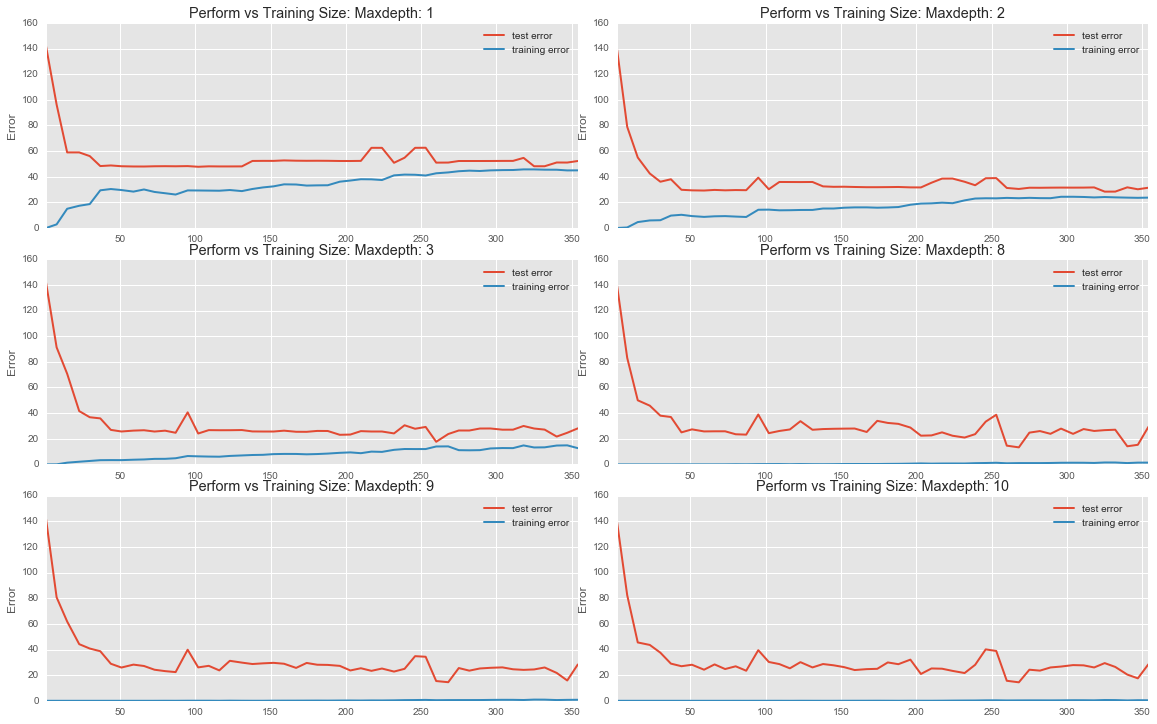

In [4]:
def learning_curve_graph2(depth, sizes, train_err, test_err, ax):
    df = pd.DataFrame({'test error': test_err, 'training error': train_err}, index=sizes)
    df.plot(ax=ax, title="Perform vs Training Size: Maxdepth: {}".format(depth), lw=2)
    #ax.set_xlabel("Training Size")
    ax.set_ylabel("Error")

def learning_curve2(depth, X_train, y_train, X_test, y_test, ax):
    """Calculate the performance of the model after a set of training data."""

    # We will vary the training set size so that we have 50 different sizes
    sizes = map(int, np.round(np.linspace(1, len(X_train), 50)))
    train_err = np.zeros(len(sizes))
    test_err = np.zeros(len(sizes))

    for i, s in enumerate(sizes):

        # Create and fit the decision tree regressor model
        regressor = DecisionTreeRegressor(max_depth=depth)
        regressor.fit(X_train[:s], y_train[:s])

        # Find the performance on the training and testing set
        train_err[i] = bh.performance_metric(y_train[:s], regressor.predict(X_train[:s]))
        test_err[i] = bh.performance_metric(y_test, regressor.predict(X_test))


    # Plot learning curve graph
    learning_curve_graph2(depth, sizes, train_err, test_err, ax)

    
X_train, y_train, X_test, y_test = bh.split_data(city_data)
fig, axes = plt.subplots(nrows=3, ncols=2)
fig.tight_layout()
axes = axes.ravel()
for i, max_depth in enumerate([1,2,3,8,9,10] ):
    learning_curve2(max_depth, X_train, y_train, X_test, y_test, axes[i])

Generally, in each of the plots above, as the size of the training data increases, the training error increases, while the test error decreases. At first, the test error drops quickly as the model sees more training data because the prameters become better tuned, but then the complexity of the model is too low to do any better with additional training data, so the rate of decrease becomes lower and lower until it almost plateaus. The increase in training error results from the bias error.
When the model complexity is low (max_depth = 1,2,3 in the above plots), the two errors near-converge with each other at the bias error. With higher complexities (max_depth = 8, 9, 10 in the above plots), the training error is low, since the model overfits the training data with high-complexity models that are overfitting. The test error is high since the model does not generalize well, and there is a gap between test error and training error.
Basically, the model with max_depth=1 suffers from high bias, while the model with max_depth=10 suffers from high variance.

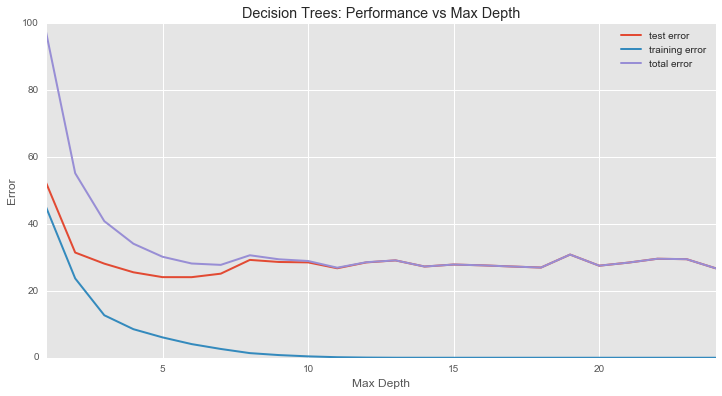

In [8]:
def model_complexity(X_train, y_train, X_test, y_test):
    """Calculate the performance of the model as model complexity increases."""

    # We will vary the depth of decision trees from 2 to 25
    max_depth = np.arange(1, 25)
    train_err = np.zeros(len(max_depth))
    test_err = np.zeros(len(max_depth))

    for i, d in enumerate(max_depth):
        # Setup a Decision Tree Regressor so that it learns a tree with depth d
        regressor = DecisionTreeRegressor(max_depth=d)

        # Fit the learner to the training data
        regressor.fit(X_train, y_train)

        # Find the performance on the training set
        train_err[i] = bh.performance_metric(y_train, regressor.predict(X_train))

        # Find the performance on the testing set
        test_err[i] = bh.performance_metric(y_test, regressor.predict(X_test))

    # Plot the model complexity graph
    model_complexity_graph(max_depth, train_err, test_err)


def model_complexity_graph(max_depth, train_err, test_err):
    """Plot training and test error as a function of the depth of the decision tree learn."""

    df = pd.DataFrame({'test error': test_err, 'training error': train_err}, index=max_depth)
    df['total error'] = df['test error'] + df['training error']
    ax = df.plot(title="Decision Trees: Performance vs Max Depth", lw=2, figsize=(12, 6))
    ax.set_xlabel("Max Depth")
    ax.set_ylabel("Error")

model_complexity(X_train, y_train, X_test, y_test)

As the model complexity increases, the test error first drops, then increases. This is because the model begins to overfit the training data at around `max_depth` of 5, so as the training error continues to decrease toward 0, the model does not do well in predicting the test data.
The total error is the sum of these two error values, and you can see that the total error begin to converge with test error after `max_depth=5`, since total error increases as test error increases. Therefore in this data split, the model with `max_depth` of around 5 will best generalize the dataset, being complex enough to capture the patterns in the training data without overfitting.

## 4) Model Prediction

In [9]:
parameters = {'max_depth':(1,2,3,4,5,6,7,8,9,10)}
x = [11.95, 0.00, 18.100, 0, 0.6590, 5.6090, 90.00, 1.385, 24, 680.0, 20.20, 332.09, 12.13]
best_max_depths = []
for i in range(100):
    X, y = city_data.data, city_data.target
    regressor = DecisionTreeRegressor()
    reg = grid_search.GridSearchCV(
        regressor, parameters, scoring='mean_squared_error', n_jobs=2,)
    reg.fit(X, y)
    y = reg.predict(np.array(x).reshape(1, -1))
    best_max_depths.append(reg.best_estimator_.max_depth)

In [14]:
# from collections import Counter
# Counter(best_max_depths).most_common(2)

In [15]:
X, y = city_data.data, city_data.target
regr = DecisionTreeRegressor(max_depth=4, criterion='mse')
regr.fit(X, y)
y = regr.predict(np.array(x).reshape(1, -1))[0]

In [17]:
# "${:6,.2f}".format(y * 1000)

In [24]:
from sklearn.neighbors import NearestNeighbors
def find_nearest_neighbor_indexes(x, X):  # x is your vector and X is the data set.
   neigh = NearestNeighbors( n_neighbors = 20 )
   neigh.fit( X)
   distance, indexes = neigh.kneighbors( np.array(x).reshape(1, -1) )
   return indexes
indexes = find_nearest_neighbor_indexes(x, X)
sum_prices = []
for i in indexes:
    sum_prices.append(city_data.target[i])
neighbor_avg = np.mean(sum_prices)
#print "Nearest Neighbors average: " +str(neighbor_avg)

Running the grid search cross validation 100 times, the most common best max_depth value was 4.
Setting the max_depth parameter to 4 results in the predicted price of \$21,629.74.
In the 100 randomized runs of GridSearchCV, 4 was the optimal max_depth value 57 times, while the next most common value was 5, which occurred 12 times.

The predicted price is a little less than the mean (~\$22.5K), but is within 1 standard deviation (~\$9K) of the mean.

Also, using `sklearn.neighbors.NearestNeighbors`, the average price for the top 10 data points who had the closest feature values to our query vector (nearest neighbors) was ~\$21.5K, and the average price for the top 20 nearest neighbors was ~\$18.2K.

Based on this result, the model seems to be reasonable, but without further analyses (i.e. feature engineering), this analysis alone is not enough to guarantee the client the best price for his or her house!